In [121]:
from pathlib import Path


from matplotlib import rcParams
from matplotlib.cm import rainbow
import math
import numpy as np
import pandas as pd


from math import sin, cos, sqrt, atan2, radians


from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn import  linear_model
from sklearn.metrics import confusion_matrix


from collections import Counter

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from xgboost import plot_importance
from matplotlib import pyplot

#Training
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


import xgboost as xgb
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)


pd.set_option("display.max_columns", 100)




/kaggle/input/ml-dataset/ML data/train.csv
/kaggle/input/ml-dataset/ML data/test.csv
/kaggle/input/ml-dataset/ML data/sample_submission.csv
/kaggle/input/ml-data/train.csv
/kaggle/input/ml-data/test.csv
/kaggle/input/ml-data/sample_submission.csv
/kaggle/input/fare-classification/meta_data.csv


In [122]:
R = 6373.0

#lable encording
def encoding_label(label):
  if(label=='correct'):
    return 1
  else:
    return 0
#calculate hours
def calculate_time(time):
    hours=time.total_seconds()
    return hours    
#calculate distance
def calculate_distance(coordinates):

#     print(coordinates['pick_lat'])
#     print(type(coordinates['pick_lat']))
    lat1 = math.radians(coordinates['pick_lat'])
    lon1 = math.radians(coordinates['pick_lon'])
    lat2 = math.radians(coordinates['drop_lat'])
    lon2 = math.radians(coordinates['drop_lon'])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = round(R * c,2)
    return distance

#Finging outliers
def calculate_outliers(data,features):
    out_liers=[]
    for feature in features:
        column_data= data[[feature]]
#         column_data.head()
        print(feature)
        column_data.sort_values(by=[feature], inplace=True)
        
        q1, q3= np.percentile(column_data,[5,99.9])
        iqr = q3 - q1
#         lower_bound = q1 -(1.5 * iqr) 
        upper_bound = q3 +(1.5 * iqr) 
        print(q1)
        print(q3)
#         outlier_list_col = column_data[(column_data < lower_bound) | (column_data > upper_bound)].index
        outlier_list_col = column_data[ (column_data > upper_bound)].index
        out_liers.extend(outlier_list_col)
    out_liers=Counter(out_liers)
    print(out_liers)
    out_liers = list(index for index,count in out_liers.items() if count > 2)
    column_data.head()
    return out_liers


def optimize_farevalue(record): 
        fare_per_distance=record['fare']/record['distance']
        fare_per_distance_per_second= fare_per_distance/record['time_difference']
        return fare_per_distance_per_second
def meter_waiting_fare_per_meter_waiting(record):
        if(record['meter_waiting']==0):
            return record['meter_waiting_fare']/1
        else:
            return record['meter_waiting_fare']/record['meter_waiting']
    
def meter_waiting_per_meter_waiting_fare(record):
        if(record['meter_waiting_fare']==0):
            return record['meter_waiting']/1
        else:
            return record['meter_waiting']/record['meter_waiting_fare']
        
def duration_per_fare(record):
        if(record['fare']== 0):
            return (record['duration']-record["meter_waiting"])/.1
        else:
            return (record['duration']-record["meter_waiting"])/record['fare']
        
def fare_per_duration(record):
        if((record['duration']-record["meter_waiting"])== 0):
            return record['fare']/.1
        else:
            return record['fare']/(record['duration']-record["meter_waiting"])
def duration_per_fare(record):
        if(record["fare"]== 0):
            return (record['duration']-record["meter_waiting"])/1 #100
        else:
            return (record['duration']-record["meter_waiting"])/record['fare']

def fare_per_distance(record):
        if(record['distance']==0):
            return record['fare']/.1  #10
        else:
            return record['fare']/record['distance']
def distance_per_fare(record):
        if(record['fare']==0):
            return record['distance']/1
        else:
            return record['distance']/record['fare']


def distance_per_duration(record):
        if((record['duration']-record["meter_waiting"])==0):
            return record['distance']/100
        else:
            return record['distance']/(record['duration']-record["meter_waiting"])
def duration_per_distance(record):
        if(record['distance']==0):
            return record['distance']/.1
        else:
            return (record['duration']-record["meter_waiting"])/record['distance']
        

Definition

In [123]:

train_data = pd.read_csv("/kaggle/input/ml-data/train.csv", index_col="tripid")
train_data["label"]=train_data["label"].apply(encoding_label).values  

test_data = pd.read_csv("/kaggle/input/ml-data/test.csv", index_col="tripid")
submissionFormatData = pd.read_csv("/kaggle/input/ml-data/sample_submission.csv", index_col="tripid")
#training_data=train_data["label"]
# index_data=test_data["tripid"]
# train_data.head()
# Trainng_feature=train_data[]
# trainng_feature= train_data.loc[:,[0:12]]


# trainng_label.head()
# test_data.head()
# train_data.columns.values
# train_data.dropna()
# train_data.dropna()


Removing outliers

In [124]:
print(len(train_data.index))

17176


In [125]:
train_data[train_data["label"]==0]["additional_fare"]

tripid
189135814    10.5
189140969    10.5
189147041    10.5
189157607    10.5
189160756    10.5
             ... 
213674502     NaN
213689462    40.5
213703973    40.5
213758346     NaN
213795752    40.5
Name: additional_fare, Length: 1681, dtype: float64

In [126]:
#train_data=train_data[(train_data['additional_fare']< 80)&(train_data['duration']< 330000)&(train_data['meter_waiting'] <400000)&(train_data['meter_waiting_fare']<22000)&(train_data['meter_waiting_till_pickup']<40000)&(train_data['fare']< 28000)]

#train_data=train_data[(train_data['additional_fare']< 220)&(train_data['duration']< 400000)&(train_data['meter_waiting'] <400000)&(train_data['meter_waiting_fare']<22000)&(train_data['meter_waiting_till_pickup']<40000)&(train_data['fare']< 25097)]

# train_data=train_data[(train_data['additional_fare']< 100)&(train_data['duration']< 400000)&(train_data['meter_waiting'] <400000)&(train_data['meter_waiting_fare']<22000)&(train_data['meter_waiting_till_pickup']<40000)&(train_data['fare']< 28000)]
#train_data=train_data[(train_data['duration']< 100000)&(train_data['meter_waiting'] <100000)&(train_data['meter_waiting_fare']<6000)&(train_data['meter_waiting_till_pickup']<4000)&(train_data['fare']< 8000)]

In [127]:
train_data[train_data["label"]==0]["additional_fare"]

tripid
189135814    10.5
189140969    10.5
189147041    10.5
189157607    10.5
189160756    10.5
             ... 
213674502     NaN
213689462    40.5
213703973    40.5
213758346     NaN
213795752    40.5
Name: additional_fare, Length: 1681, dtype: float64

In [128]:
#graph distribution of quantitative data
# plt.figure(figsize=[16,12])

# plt.subplot(231)
# plt.boxplot(x=train_data['duration'], showmeans = True, meanline = True)
# plt.title('duration')
# plt.ylabel('duration ($)')

In [129]:
#graph distribution of quantitative data
# plt.figure(figsize=[16,12])

# plt.subplot(231)
# plt.boxplot(x=train_data['meter_waiting'], showmeans = True, meanline = True)
# plt.title('meter_waiting')
# plt.ylabel('meter_waiting ($)')

In [130]:
#graph distribution of quantitative data
# plt.figure(figsize=[16,12])

# plt.subplot(231)
# plt.boxplot(x=train_data['meter_waiting_fare'], showmeans = True, meanline = True)
# plt.title('meter_waiting_fare')
# plt.ylabel('meter_waiting_fare ($)')


In [131]:
#graph distribution of quantitative data
# plt.figure(figsize=[16,12])

# plt.subplot(231)
# plt.boxplot(x=train_data['meter_waiting_till_pickup'], showmeans = True, meanline = True)
# plt.title('meter_waiting_till_pickup')
# plt.ylabel('meter_waiting_till_pickup ($)')

In [132]:
#graph distribution of quantitative data
# plt.figure(figsize=[16,12])

# plt.subplot(231)
# plt.boxplot(x=train_data['fare'], showmeans = True, meanline = True)
# plt.title('fare')
# plt.ylabel('fare ($)')

In [133]:
#graph distribution of quantitative data
# plt.figure(figsize=[16,12])

# plt.subplot(231)
# plt.boxplot(x=train_data['additional_fare'], showmeans = True, meanline = True)
# plt.title('additional_fare')
# plt.ylabel('additional_fare ($)')


In [134]:
print(len(train_data.index))

17176


In [135]:
# #Reemove NAN tuples
# train_data.dropna(inplace=True)
# #dropNAN columns from test list
# NANcolumns=test_data.columns[test_data.isna().any()].tolist()
# #remove tuples from submissionData
# submissionFormatData.drop(NANcolumns)
# test_data.dropna(inplace=True)

In [136]:
# # out_liers= calculate_outliers(train_data, ["duration","meter_waiting","meter_waiting_fare","fare","pick_lat","pick_lon","drop_lat","drop_lon"])
# # out_liers= calculate_outliers(train_data, ["additional_fare","duration","meter_waiting","meter_waiting_fare","fare"])
# out_liers= calculate_outliers(train_data, ["meter_waiting_fare"])
# out_liers
# train_data.drop(out_liers,inplace=True)

Data Preprocessing

In [137]:
#189128020
train_data.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
tripid,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,1
189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,1
189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,1
189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,1
189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,1


In [138]:
# NANcolumns=trainng_feature.columns[trainng_feature.isna().any()].tolist()
# print(NANcolumns)

In [139]:

# train_data['pickup_time'] = pd.to_datetime(train_data['pickup_time'],format='%m/%d/%Y %H:%M')
# train_data['drop_time'] = pd.to_datetime(train_data['drop_time'],format='%m/%d/%Y %H:%M')
# test_data['pickup_time'] = pd.to_datetime(test_data['pickup_time'],format='%m/%d/%Y %H:%M')
# test_data['drop_time'] = pd.to_datetime(test_data['drop_time'],format='%m/%d/%Y %H:%M')


# train_data['time_difference']=train_data['drop_time']-train_data['pickup_time']
# train_data['time_difference']=train_data['time_difference'].apply(calculate_time).values
# test_data['time_difference']=test_data['drop_time']-test_data['pickup_time']
# test_data['time_difference']=test_data['time_difference'].apply(calculate_time).values

# #calculate distance

# # trainng_feature['time_difference']=trainng_feature['time_difference'].days
# # trainng_feature['pyear']=trainng_feature['pickup_time'].dt.year 
# # trainng_feature['pmonth']=trainng_feature['pickup_time'].dt.month 
# # trainng_feature['pday']=trainng_feature['pickup_time'].dt.day
# # trainng_feature['pdayofweek_num']=trainng_feature['pickup_time'].dt.dayofweek 
# # trainng_feature['pHour'] = trainng_feature['pickup_time'].dt.hour 
# # trainng_feature['pminute'] = trainng_feature['pickup_time'].dt.minute 




# train_data=train_data.drop(['pickup_time','drop_time'],axis=1)
# test_data=test_data.drop(['pickup_time','drop_time'],axis=1)
# # trainng_feature['dyear']=trainng_feature['drop_time'].dt.year 
# # trainng_feature['dmonth']=trainng_feature['drop_time'].dt.month 
# # trainng_feature['dday']=trainng_feature['drop_time'].dt.day
# # trainng_feature['ddayofweek_num']=trainng_feature['drop_time'].dt.dayofweek 
# # trainng_feature['dHour'] = trainng_feature['drop_time'].dt.hour 
# # trainng_feature['dminute'] = trainng_feature['drop_time'].dt.minute 
# # test_data.isnull().sum()

# #merginh two dataframes
train_data.insert(train_data.columns.get_loc('fare'), 'distance', train_data[['pick_lat','pick_lon','drop_lat','drop_lon']].apply(calculate_distance,axis = 1))
test_data.insert(test_data.columns.get_loc('fare'), 'distance', test_data[['pick_lat','pick_lon','drop_lat','drop_lon']].apply(calculate_distance,axis = 1))
# train_data["distance"]=train_data[['pick_lat','pick_lon','drop_lat','drop_lon']].apply(calculate_distance,axis = 1)
# test_data["distance"]=test_data[['pick_lat','pick_lon','drop_lat','drop_lon']].apply(calculate_distance,axis = 1)
# #
# # trainng_feature['fare']=trainng_feature.apply(optimize_farevalue,axis = 1)
# # test_data['fare']=test_data.apply(optimize_farevalue,axis = 1)
# # drop columns
# train_data=train_data.drop(['pick_lat','pick_lon','drop_lat','drop_lon'],axis=1)
# test_data=test_data.drop(['pick_lat','pick_lon','drop_lat','drop_lon'],axis=1)


train_data

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,distance,fare,label
tripid,,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,5.09,270.32,1
189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,3.17,197.85,1
189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,6.31,301.64,1
189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,0.86,82.30,1
189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,8.15,358.39,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213803193,10.5,838.0,93.0,5.4219,451.0,1/31/2020 22:07,1/31/2020 22:21,7.29073,80.6367,7.28891,80.6557,2.11,198.26,1
213812756,10.5,2151.0,428.0,0.0000,39.0,1/31/2020 23:07,1/31/2020 23:43,6.90569,79.8516,6.95089,79.9389,10.87,581.23,1
213813930,10.5,263.0,9.0,0.0000,110.0,1/31/2020 23:21,1/31/2020 23:25,7.09210,79.9000,7.10135,79.9017,1.05,76.20,1


In [140]:
train_data=train_data.drop(['pick_lat','pick_lon','drop_lat','drop_lon','meter_waiting_till_pickup','pickup_time','drop_time'],axis=1)
test_data=test_data.drop(['pick_lat','pick_lon','drop_lat','drop_lon','meter_waiting_till_pickup','pickup_time','drop_time'],axis=1)

# train_data=train_data.drop(['pick_lat','pick_lon','drop_lat','drop_lon','pickup_time','drop_time'],axis=1)
# test_data=test_data.drop(['pick_lat','pick_lon','drop_lat','drop_lon','pickup_time','drop_time'],axis=1)

In [141]:
train_data

,additional_fare,duration,meter_waiting,meter_waiting_fare,distance,fare,label
tripid,,,,,,,
189123628,10.5,834.0,56.0,0.0000,5.09,270.32,1
189125358,10.5,791.0,47.0,0.0000,3.17,197.85,1
189125719,10.5,1087.0,80.0,0.0000,6.31,301.64,1
189127273,10.5,598.0,271.0,15.6638,0.86,82.30,1
189128020,NaN,NaN,NaN,NaN,8.15,358.39,1
...,...,...,...,...,...,...,...
213803193,10.5,838.0,93.0,5.4219,2.11,198.26,1
213812756,10.5,2151.0,428.0,0.0000,10.87,581.23,1
213813930,10.5,263.0,9.0,0.0000,1.05,76.20,1


In [142]:
# df[df.name != 'Tina']

In [143]:
train_data["label"].value_counts()

1    15495
0     1681
Name: label, dtype: int64

In [144]:
#replace duration NAN values with time difference
# train_data["duration"].fillna(train_data["time_difference"], inplace = True)
#calculate duration without immobile time

In [145]:
train_data.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,distance,fare,label
tripid,,,,,,,
189123628,10.5,834.0,56.0,0.0000,5.09,270.32,1
189125358,10.5,791.0,47.0,0.0000,3.17,197.85,1
189125719,10.5,1087.0,80.0,0.0000,6.31,301.64,1
189127273,10.5,598.0,271.0,15.6638,0.86,82.30,1
189128020,NaN,NaN,NaN,NaN,8.15,358.39,1


In [146]:
# NANcolumns=trainng_feature.columns[trainng_feature.isna().any()].tolist()
# print(NANcolumns)

In [147]:
# train_data['additional_fare'] = train_data['additional_fare'].fillna(train_data['additional_fare'].median())

In [148]:
# lableList=[0,1]
# for lable in lableList:
#       train_data[train_data['label']==lable]=train_data[train_data['label']==lable].fillna((train_data[(train_data['label']==lable)]).mean())
# #     train_data[(train_data['label']==lable)]['additional_fare'].fillna((train_data[(train_data['label']==lable)]['additional_fare'].mean()), inplace = True)
# #     train_data[(train_data['label']==lable)]['meter_waiting'].fillna(( train_data[(train_data['label']==lable)]['meter_waiting'].mean()), inplace = True)
# #     train_data[(train_data['label']==lable)]['meter_waiting_fare'].fillna((train_data[(train_data['label']==lable)]['meter_waiting_fare'].mean()), inplace = True)
# #     train_data[(train_data['label']==lable)]['meter_waiting_till_pickup'].fillna(( train_data[(train_data['label']==lable)]['meter_waiting_till_pickup'].mean()), inplace = True)
# #     train_data[(train_data['label']==lable)]['fare'].fillna((train_data[(train_data['label']==lable)]['fare'].mean()), inplace = True)
#       print((train_data[(train_data['label']==lable)]).mean())
   


In [149]:
# train_data[train_data["label"]==0]["additional_fare"]

In [150]:
# train_data[train_data["label"]==1]["additional_fare"]

In [151]:
# data_cleaner=[train_data['label'= 'correct'],train_data['label'= 'incorrect']]

    


In [152]:
trainng_label= train_data["label"]
# trainng_feature= train_data["additional_fare","duration","meter_waiting","meter_waiting_fare","meter_waiting_till_pickup","fare","time_difference","distance" ]
trainng_feature= train_data.drop(["label"],axis=1)

In [153]:

# trainng_feature["duration"]=trainng_feature["duration"]-trainng_feature["meter_waiting"]
# test_data["duration"]=test_data["duration"]-test_data["meter_waiting"]

# trainng_feature["duration"]=trainng_feature["time_difference"]-trainng_feature["meter_waiting"]
# test_data["duration"]=test_data["time_difference"]-test_data["meter_waiting"]

#calculate fare without meter_waiting_fare
# trainng_feature["fare"]=trainng_feature["fare"]-trainng_feature["meter_waiting_fare"]
# test_data["fare"]=test_data["fare"]-test_data["meter_waiting_fare"]



In [154]:
# train_data.insert(train_data.columns.get_loc('distance'),"fare_Per_duration" ,train_data["fare"]/train_data["duration"])
# test_data.insert(test_data.columns.get_loc('distance'),"fare_Per_duration" ,test_data["fare"]/test_data["duration"])

# train_data.insert(train_data.columns.get_loc('distance'),"duration_per_fare",(train_data["duration"]-train_data["meter_waiting"])/train_data["fare"])
# test_data.insert(test_data.columns.get_loc('distance'),"duration_per_fare" , (test_data["duration"]-test_data["meter_waiting"])/test_data["fare"])


# test_X.insert(test_X.columns.get_loc('fare'), 'distance', dist)

In [155]:
# trainng_feature["fare"]=trainng_feature["fare"]-trainng_feature["additional_fare"]-trainng_feature["meter_waiting_fare"]
# trainng_feature["duration"]=trainng_feature["duration"]/(trainng_feature["fare"]- trainng_feature["meter_waiting_fare"])
# test_data["duration"]=test_data["duration"]/(test_data["fare"]-test_data["meter_waiting_fare"])
###############################################################################
# trainng_feature["duration"]=trainng_feature["duration"]/trainng_feature["fare"]
# test_data["duration"]=test_data["duration"]/test_data["fare"]

# trainng_feature["duration_per_fare"]=(trainng_feature["duration"]-trainng_feature["meter_waiting"])/trainng_feature["fare"]
# test_data["duration_per_fare"]=(test_data["duration"]-test_data["meter_waiting"])/test_data["fare"]

###
trainng_feature["fare_Per_duration"]=trainng_feature.apply(fare_per_duration,axis = 1)
test_data["fare_Per_duration"]=test_data.apply(fare_per_duration,axis = 1)



#####
trainng_feature["duration_per_fare"]=trainng_feature.apply(duration_per_fare,axis = 1)
test_data["duration_per_fare"]=test_data.apply(duration_per_fare,axis = 1)



# trainng_feature["fare_Per_duration"]=trainng_feature["fare"]/trainng_feature["duration"]
# test_data["fare_Per_duration"]=test_data["fare"]/test_data["duration"]

# trainng_feature['fare_per_distance']=trainng_feature.apply(fare_per_distance,axis = 1)
# test_data['fare_per_distance']=test_data.apply(fare_per_distance,axis = 1)
#####
# trainng_feature['distance_per_fare']=trainng_feature.apply(distance_per_fare,axis = 1)
# test_data['distance_per_fare']=test_data.apply(distance_per_fare,axis = 1)

# trainng_feature['distance_per_fare']=trainng_feature["distance"]/trainng_feature["fare"]
# test_data['distance_per_fare']=test_data["distance"]/test_data["fare"]

# trainng_feature['fare_per_distance']=trainng_feature["fare"]/trainng_feature["distance"]
# test_data['fare_per_distance']=test_data["fare"]/test_data["distance"]
# trainng_feature['distance_per_duration']=trainng_feature.apply(distance_per_duration,axis = 1)
# test_data['distance_per_duration']=test_data.apply(distance_per_duration,axis = 1)
# trainng_feature["time_difference"]=trainng_feature["time_difference"]/trainng_feature["fare"]
# test_data["time_difference"]=test_data["time_difference"]/test_data["fare"]
#this is ok
trainng_feature['duration_per_distance']=trainng_feature.apply(duration_per_distance,axis = 1)
test_data['duration_per_distance']=test_data.apply(duration_per_distance,axis = 1)
# trainng_feature['duration_per_distance']=(trainng_feature["duration"]-trainng_feature["meter_waiting"])/trainng_feature["distance"]
# test_data['duration_per_distance']=(test_data["duration"]-test_data["meter_waiting"])/test_data["distance"]

# trainng_feature['distance_per_duration']=trainng_feature.apply(distance_per_duration,axis = 1)
# test_data['distance_per_duration']=test_data.apply(distance_per_duration,axis = 1)

# trainng_feature["time_difference_per_fare"]=trainng_feature.apply(time_difference_per_fare,axis = 1)
# test_data["time_difference_per_fare"]=test_data.apply(time_difference_per_fare,axis = 1)
###############################################################################


# trainng_feature["meter_waiting_till_pickup"]=trainng_feature["meter_waiting_till_pickup"]/trainng_feature["fare"]
# test_data["meter_waiting_till_pickup"]=test_data["meter_waiting_till_pickup"]/test_data["fare"]

# trainng_feature["meter_waiting_till_pickup"]=trainng_feature["distance"]
# test_data["meter_waiting_till_pickup"]=test_data["distance"]

# trainng_feature["fare"]=trainng_feature["fare"]/trainng_feature["distance"]
# test_data["fare"]=test_data["fare"]/test_data["distance"]

# trainng_feature['meter_waiting_fare_per_meter_waiting']=trainng_feature.apply(meter_waiting_fare_per_meter_waiting,axis = 1)
# test_data['meter_waiting_fare_per_meter_waiting']=test_data.apply(meter_waiting_fare_per_meter_waiting,axis = 1)

trainng_feature['meter_waiting_per_meter_waiting_fare']=trainng_feature.apply(meter_waiting_per_meter_waiting_fare,axis = 1)
test_data['meter_waiting_per_meter_waiting_fare']=test_data.apply(meter_waiting_per_meter_waiting_fare,axis = 1)

# trainng_feature["meter_waiting_till_pickup"]=trainng_feature["meter_waiting_till_pickup"]/trainng_feature["additional_fare"]
# test_data["meter_waiting_till_pickup"]=test_data["meter_waiting_till_pickup"]/test_data["additional_fare"]

# trainng_feature['distance_per_duration']=trainng_feature.apply(distance_per_duration,axis = 1)
# test_data['distance_per_duration']=test_data.apply(distance_per_duration,axis = 1)

# trainng_feature['distance_per_duration']=trainng_feature["distance"]/trainng_feature["duration"]
# test_data['distance_per_duration']=test_data["distance"]/test_data["duration"]


# trainng_feature["meter_waiting"]=trainng_feature["meter_waiting"]/3600
# test_data["meter_waiting"]=test_data["meter_waiting"]/3600
# train_data=train_data.drop(['duration','fare','meter_waiting_fare','distance'],axis=1)
# test_data=test_data.drop(['duration','fare','meter_waiting_fare','distance'],axis=1)

# trainng_feature["fare"]=trainng_feature["fare"]/trainng_feature["distance"]
# test_data["fare"]=test_data["fare"]/test_data["distance"]

train_data.head()




,additional_fare,duration,meter_waiting,meter_waiting_fare,distance,fare,label
tripid,,,,,,,
189123628,10.5,834.0,56.0,0.0000,5.09,270.32,1
189125358,10.5,791.0,47.0,0.0000,3.17,197.85,1
189125719,10.5,1087.0,80.0,0.0000,6.31,301.64,1
189127273,10.5,598.0,271.0,15.6638,0.86,82.30,1
189128020,NaN,NaN,NaN,NaN,8.15,358.39,1


In [156]:
# trainng_feature[trainng_feature["distance"]==0]

In [157]:
# trainng_feature[train_data["fare"]==0]

In [158]:
# trainng_feature[train_data["duration"]==0]

In [159]:
# NANcolumns=trainng_feature.columns[trainng_feature.isna().any()].tolist()
# print(NANcolumns)

In [160]:
#feature engineering




trainng_feature
# trainng_feature.isnull().sum()

,additional_fare,duration,meter_waiting,meter_waiting_fare,distance,fare,fare_Per_duration,duration_per_fare,duration_per_distance,meter_waiting_per_meter_waiting_fare
tripid,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,5.09,270.32,0.347455,2.878070,152.848723,56.000000
189125358,10.5,791.0,47.0,0.0000,3.17,197.85,0.265927,3.760425,234.700315,47.000000
189125719,10.5,1087.0,80.0,0.0000,6.31,301.64,0.299543,3.338417,159.587956,80.000000
189127273,10.5,598.0,271.0,15.6638,0.86,82.30,0.251682,3.973269,380.232558,17.301038
189128020,NaN,NaN,NaN,NaN,8.15,358.39,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
213803193,10.5,838.0,93.0,5.4219,2.11,198.26,0.266121,3.757692,353.080569,17.152659
213812756,10.5,2151.0,428.0,0.0000,10.87,581.23,0.337336,2.964403,158.509660,428.000000
213813930,10.5,263.0,9.0,0.0000,1.05,76.20,0.300000,3.333333,241.904762,9.000000


Check for outliers

In [161]:
# numerical_cols = trainng_feature.columns[trainng_feature.dtypes != "object"].values

In [162]:
# numerical_cols

In [163]:
# numeric_preprocessing_steps = Pipeline([
#     ('standard_scaler', StandardScaler()),
#     ('simple_imputer', SimpleImputer(strategy='mean'))
# ])

# preprocessor = ColumnTransformer(
#     transformers = [
#         ("numeric", numeric_preprocessing_steps, numerical_cols)
#     ],
#     remainder = "drop"
# )

Parameter tuning

In [164]:
# rf = RandomForestRegressor(random_state = 42)
# print('Parameters currently in use:\n')
# pprint(rf.get_params())

In [165]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'estimator__n_estimators': n_estimators,
               'estimator__max_features': max_features,
               'estimator__max_depth': max_depth,
               'estimator__min_samples_split': min_samples_split,
               'estimator__min_samples_leaf': min_samples_leaf,
               'estimator__bootstrap': bootstrap}

param_grid = {
    'estimator__bootstrap': [True],
    'estimator__max_depth': [80, 90, 100, 110],
    'estimator__max_features': [2, 3],
    'estimator__min_samples_leaf': [3, 4, 5],
    'estimator__min_samples_split': [8, 10, 12],
    'estimator__n_estimators': [100, 200, 300, 1000]
}


param_test1 = {
 'estimator__max_depth':range(3,10,2),
 'estimator__min_child_weight':range(1,6,2)
}
param_test2 = {
 'estimator__max_depth':[2,3,4],
 'estimator__min_child_weight':[4,5,6]
}

param_test2a = {
 'estimator__max_depth':[4,6,8,10]
}

# param_test2b = {
#  'estimator__min_child_weight':[3,5,7,9]
# }
param_test2b = {
 'estimator__min_child_weight':[6,7,8]
}
# param_test2b = {
#  'estimator__min_child_weight':[10,12,14,16]
# }


param_test3 = {
 'estimator__gamma':[i/10.0 for i in range(0,5)]
}
param_test4 = {
 'estimator__subsample':[i/10.0 for i in range(6,10)],
 'estimator__colsample_bytree':[i/10.0 for i in range(6,10)]
}
param_test5 = {
 'estimator__subsample':[i/100.0 for i in range(75,90,5)],
 'estimator__colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
param_test6 = {
 'estimator__reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
} 
#0.006737947
param_test7 = {
 'estimator__reg_alpha':[0,0.01,0.1, 0.5, 0.05]
}
# param_test7 = {
#  'estimator__reg_alpha':[0, 0.00006737947,0.00033689735, 0.0006737947, 0.0033689735]
# }

param_test8 = {
 'estimator__reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
 'estimator__reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]
} 
param_test8b = {
 'estimator__reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
 'estimator__reg_lambda':[100, 100.1, 99,99.9, 101]
} 
param_test9 = {
 'estimator__base_score':[i/10.0 for i in range(0,10)]
 
} 
param_test9b = {
 'estimator__base_score':[i/100.0 for i in range(0,10)]
 
} 
param_test10 ={
    'estimator__n_estimators': range(50,1000,50)
}
param_test10 ={
    'estimator__scale_pos_weight':  [1, 10, 25, 50, 75, 99, 100, 1000]
}
parameters = {"estimator__learning_rate": [0.1, 0.01, 0.001],
               "estimator__gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
               "estimator__max_depth": [2, 4, 7, 10],
               "estimator__colsample_bytree": [0.3, 0.6, 0.8, 1.0],
               "estimator__subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
               "estimator__reg_alpha": [0, 0.5, 1],
               "estimator__reg_lambda": [1, 1.5, 2, 3, 4.5],
               "estimator__min_child_weight": [1, 3, 5, 7],
               "estimator__n_estimators": [100, 250, 500, 1000]}

parameters2 = {"estimator__learning_rate": [0.1, 0.01, 0.001],
               "estimator__gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
               "estimator__max_depth": [2, 4, 7, 10],
               "estimator__colsample_bytree": [0.3, 0.6, 0.8, 1.0],
               "estimator__subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
               "estimator__reg_alpha": [0, 0.5, 1],
               "estimator__reg_lambda": [1, 1.5, 2, 3, 4.5],
               "estimator__min_child_weight": [1, 3, 5, 7],
               "estimator__n_estimators": [100, 250, 500, 1000],
               "estimator__scale_pos_weight" :[i/10.0 for i in range(0,10)],
               "estimator__base_score" : [i/10.0 for i in range(0,10)],
               "estimator__max_delta_step" : [i for i in range(0,10)]}
                
specific_parameters={
               "estimator__scale_pos_weight" :[i/10.0 for i in range(0,10)],
               "estimator__base_score" : [i/10.0 for i in range(0,10)],
               "estimator__max_delta_step" : [i for i in range(0,10)]
    
    
}


pprint(random_grid)

{'estimator__bootstrap': [True, False],
 'estimator__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'estimator__max_features': ['auto', 'sqrt'],
 'estimator__min_samples_leaf': [1, 2, 4],
 'estimator__min_samples_split': [2, 5, 10],
 'estimator__n_estimators': [200,
                             400,
                             600,
                             800,
                             1000,
                             1200,
                             1400,
                             1600,
                             1800,
                             2000]}


In [166]:
# estimator=MultiOutputClassifier(

# estimator=RandomForestClassifier(     
# #          n_estimators = 1400,
# #          min_samples_split= 5,
# #          min_samples_leaf= 1,
# #          max_features = 'sqrt',
# #          max_depth = 30,
# #          bootstrap = True
                                    
                                    
#     )
# )

#fail
# estimator=xgb.XGBClassifier(
#          reg_alpha=0,
#          learning_rate =0.1,
#          n_estimators=1000,
# #          max_depth=3,
# #          min_child_weight=1,
#          max_depth=3,
#          min_child_weight=6,
#          gamma=0,
#          subsample=0.6,
#          colsample_bytree=0.8,
#          objective= 'binary:logistic',
#          nthread=4,
#          scale_pos_weight=1,
#          seed=27
       
#         )

#newone # not optimized well
# estimator=xgb.XGBClassifier(
#      reg_alpha = 0.00033689735,
#      learning_rate = 0.01,
#      n_estimators = 1000,
#      max_depth=3,
#      min_child_weight=2,
#      gamma=0.4,
#      subsample=0.8,
#      colsample_bytree=0.75,
#      objective= 'binary:logistic',
#      nthread=4,
#      scale_pos_weight=1,
#      seed=27
#     )

#2ndTime
# estimator=xgb.XGBClassifier(
#          reg_alpha=0,
#          learning_rate =0.1,
#          n_estimators=1000,
# #          max_depth=3,
# #          min_child_weight=1,
#          max_depth=4,
#          min_child_weight=3,
#          gamma=0,
#          subsample=0.6,
#          colsample_bytree=0.8,
#          objective= 'binary:logistic',
#          nthread=4,
#          scale_pos_weight=1,
#          seed=27
       
#         )
#3rdTime 
# estimator=xgb.XGBClassifier(
#      learning_rate =0.1,
#      n_estimators=1000,
#      max_depth=3,
#      min_child_weight=1,
#      gamma=0,
#      subsample=0.6,
#      colsample_bytree=0.7,
#      objective= 'binary:logistic',
#      nthread=4,
#      scale_pos_weight=1,
#      seed=27)
# 4thTime 
# estimator= xgb.XGBClassifier(
#      reg_alpha=1,
#      learning_rate =0.1,
#      n_estimators=1000,
#      max_depth=3,
#      min_child_weight=6,
#      gamma=0,
#      subsample=0.85,
#      colsample_bytree=0.75,
#      objective= 'binary:logistic',
#      nthread=4,
#      scale_pos_weight=1,
#      seed=27
# )
#current one
estimator = xgb.XGBClassifier (
      learning_rate =0.2,
#       n_estimators=200,
#       base_score=.1
 
)    
#      learning_rate =0.1,
#      n_estimators=1000,
#      max_depth=5,
#      min_child_weight=1,
#      gamma=0,
#      subsample=0.8,
#      colsample_bytree=0.8,
#      objective= 'binary:logistic',
#      nthread=4,
#      scale_pos_weight=1,
#      seed=27
    
#        n_estimators=200,
#        base_score=.1,
    
    
#     base_score = 0.9,
#  max_delta_step= 8,
#  scale_pos_weight= 0.7
#        learning_rate =0.1,
#        n_estimators=200,
#        base_score=.1,
#        scale_pos_weight= 0.108
#        reg_alpha = .05
#      max_depth=2,
#      min_child_weight=5,
#      gamma=0,
#      subsample=0.9,
#      colsample_bytree=0.9,
#       objective= 'binary:logistic',
#      nthread=4,
#      scale_pos_weight=1,
#      seed=27,
#      reg_alpha = 0,
#      reg_lambda = 1
    
      


#initialOne
# estimator= xgb.XGBClassifier(
#      learning_rate =0.1,
#      n_estimators=1000,
#      max_depth=5,
#      min_child_weight=1,
#      gamma=0,
#      subsample=0.8,
#      colsample_bytree=0.8,
#      objective= 'binary:logistic',
#      nthread=4,
#      scale_pos_weight=1,
#      seed=27
# )
# basecore=.1
# esti=200
#Firstime
# estimator=RandomForestClassifier(     
# #          n_estimators = 1400,
# #          min_samples_split= 5,
# #          min_samples_leaf= 1,
# #          max_features = 'sqrt',
# #          max_depth = 30,
# #          bootstrap = True
#             max_depth=90,
#             max_features=3,
#             min_samples_leaf=3,
#             min_samples_split=8,
#             n_estimators=1000,
#             bootstrap=True,
#             random_state=45
                                    
#     )

In [167]:
# full_pipeline = Pipeline([
# #     ("preprocessor", preprocessor),
#     ("estimator", estimator),
# ])
# pprint(full_pipeline.get_params().keys())

In [168]:
# print(type(trainng_label))
# Use the random grid to search for best hyperparameters
# First create the base model to tune
# rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(full_pipeline, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1,scoring ='f1')
# Fit the random search model
# rf_random.fit( trainng_feature, trainng_label)

#XgBoosting

# data_dmatrix = xgb.DMatrix(data=trainng_feature,label=trainng_label)

# params = {"estimator__objective":"binary:logistic",'estimator__colsample_bytree': 0.3,'estimator__learning_rate': 0.1,
#                 'estimator__max_depth': 5, 'estimator__alpha': 10}

# cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
#                     num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

# cv_results.head()

In [169]:
# grid_search = GridSearchCV(full_pipeline, param_grid = param_grid,cv = 3, n_jobs = -1, verbose = 2,scoring ='f1')
# grid_search.fit( trainng_feature, trainng_label)

# grid_search = GridSearchCV(full_pipeline, param_grid =specific_parameters,cv = 5, n_jobs = -1, verbose = 2,scoring ='f1')
# grid_search.fit( trainng_feature, trainng_label)

In [170]:
# rf_random.best_params_
# grid_search.best_estimator_
# grid_search.best_params_
# grid_search.grid_scores_, 
# grid_search.best_params_, grid_search.best_score_

Creating the dataset

In [171]:
X_train, X_eval, y_train, y_eval = train_test_split(
    trainng_feature,
    trainng_label,
    test_size=0.33,
    shuffle=True,
    stratify= trainng_label,
    random_state=6
)
# X_train.head()

y_train.shape

(11507,)

In [172]:

y_train

tripid
205667210    0
193277385    1
201668211    1
204263911    0
206929715    1
            ..
194581383    1
210262618    1
193567198    1
195794965    1
208711842    1
Name: label, Length: 11507, dtype: int64

In [173]:
X_train

,additional_fare,duration,meter_waiting,meter_waiting_fare,distance,fare,fare_Per_duration,duration_per_fare,duration_per_distance,meter_waiting_per_meter_waiting_fare
tripid,,,,,,,,,,
205667210,10.5,4439.0,1875.0,108.416715,3.47,783.39,0.305534,3.272955,738.904899,17.294381
193277385,10.5,347.0,2.0,0.000000,2.03,122.44,0.354899,2.817707,169.950739,2.000000
201668211,10.5,1133.0,121.0,0.000000,3.82,208.80,0.206324,4.846743,264.921466,121.000000
204263911,NaN,NaN,NaN,NaN,7.10,NaN,NaN,NaN,NaN,NaN
206929715,10.5,1280.0,80.0,0.000000,7.12,270.14,0.225117,4.442141,168.539326,80.000000
...,...,...,...,...,...,...,...,...,...,...
194581383,10.5,375.0,6.0,0.354339,1.44,102.96,0.279024,3.583916,256.250000,16.932931
210262618,10.5,707.0,40.0,2.332000,1.51,170.37,0.255427,3.915009,441.721854,17.152659
193567198,10.5,2081.0,396.0,23.086800,7.64,349.20,0.207240,4.825315,220.549738,17.152659


In [174]:
trainng_feature.columns

Index(['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare',
       'distance', 'fare', 'fare_Per_duration', 'duration_per_fare',
       'duration_per_distance', 'meter_waiting_per_meter_waiting_fare'],
      dtype='object')

In [175]:
test_data.columns

Index(['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare',
       'distance', 'fare', 'fare_Per_duration', 'duration_per_fare',
       'duration_per_distance', 'meter_waiting_per_meter_waiting_fare'],
      dtype='object')

Train the model

In [176]:
  
estimator.fit(X_train, y_train)

# Predict on evaluation set
# This competition wants probabilities, not labels
preds = estimator.predict(X_eval)
preds


array([1, 1, 1, ..., 1, 0, 1])

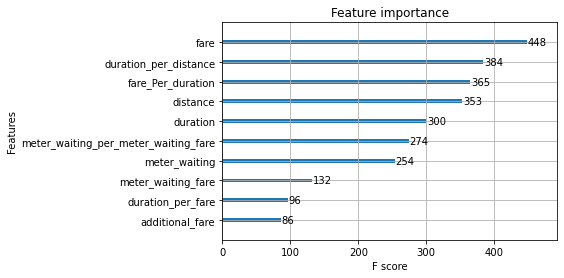

In [177]:
plot_importance(estimator)
pyplot.show()

In [178]:
print("test_probas[0].shape", preds.shape)

test_probas[0].shape (5669,)


In [179]:
y_preds = pd.DataFrame(
    {
        "prediction": preds
    },
    index = y_eval.index
)
print("y_preds.shape:", y_preds.shape)
y_preds.head()

y_preds.shape: (5669, 1)


,prediction
tripid,
207281621,1
209841908,1
207398166,1
205322558,1
194991764,1


Test model

In [180]:

kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
cv_results = cross_val_score(estimator, trainng_feature, trainng_label, cv=kfold, scoring='f1')
cv_results

array([0.97288676, 0.97830249, 0.96963886, 0.97293855, 0.97726545,
       0.97452229, 0.98113208, 0.97606128, 0.98049248, 0.97480064])

In [181]:
confusion_matrix(y_eval,y_preds)

array([[ 371,  184],
       [  60, 5054]])

In [182]:
f1_score(y_eval, y_preds, average='macro')

0.8644825861912211

In [183]:
test_data

,additional_fare,duration,meter_waiting,meter_waiting_fare,distance,fare,fare_Per_duration,duration_per_fare,duration_per_distance,meter_waiting_per_meter_waiting_fare
tripid,,,,,,,,,,
213284604,10.5,924,42,2.44860,6.71,289.27,0.327971,3.049055,131.445604,17.152659
213286352,10.5,4249,20,0.00000,41.57,1912.70,0.452282,2.211011,101.732018,20.000000
213293973,10.5,1552,255,2.65880,5.92,394.00,0.303778,3.291878,219.087838,95.907928
213294622,10.5,462,16,0.00000,3.30,154.32,0.346009,2.890098,135.151515,16.000000
213298687,10.5,814,392,12.36920,2.59,147.47,0.349455,2.861599,162.934363,31.691621
...,...,...,...,...,...,...,...,...,...,...
222856243,10.5,1723,429,24.83332,3.94,388.48,0.300216,3.330931,328.426396,17.275177
222857785,10.5,1378,80,0.00000,7.52,379.85,0.292643,3.417138,172.606383,80.000000
222858416,10.5,418,56,3.28440,2.06,112.79,0.311575,3.209504,175.728155,17.050298


In [184]:
trainng_label

tripid
189123628    1
189125358    1
189125719    1
189127273    1
189128020    1
            ..
213803193    1
213812756    1
213813930    1
213815405    1
213817296    1
Name: label, Length: 17176, dtype: int64

In [185]:
model=xgb.XGBClassifier(
         learning_rate=0.2,
#          n_estimators=200,
#          base_score=.1
                            ) 

In [186]:
model.fit(trainng_feature, trainng_label)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.2, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [187]:
trainng_feature

,additional_fare,duration,meter_waiting,meter_waiting_fare,distance,fare,fare_Per_duration,duration_per_fare,duration_per_distance,meter_waiting_per_meter_waiting_fare
tripid,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,5.09,270.32,0.347455,2.878070,152.848723,56.000000
189125358,10.5,791.0,47.0,0.0000,3.17,197.85,0.265927,3.760425,234.700315,47.000000
189125719,10.5,1087.0,80.0,0.0000,6.31,301.64,0.299543,3.338417,159.587956,80.000000
189127273,10.5,598.0,271.0,15.6638,0.86,82.30,0.251682,3.973269,380.232558,17.301038
189128020,NaN,NaN,NaN,NaN,8.15,358.39,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
213803193,10.5,838.0,93.0,5.4219,2.11,198.26,0.266121,3.757692,353.080569,17.152659
213812756,10.5,2151.0,428.0,0.0000,10.87,581.23,0.337336,2.964403,158.509660,428.000000
213813930,10.5,263.0,9.0,0.0000,1.05,76.20,0.300000,3.333333,241.904762,9.000000


In [188]:

# trainng_label= train_data["label"]

In [189]:
trainng_label

tripid
189123628    1
189125358    1
189125719    1
189127273    1
189128020    1
            ..
213803193    1
213812756    1
213813930    1
213815405    1
213817296    1
Name: label, Length: 17176, dtype: int64

In [190]:
test_data

,additional_fare,duration,meter_waiting,meter_waiting_fare,distance,fare,fare_Per_duration,duration_per_fare,duration_per_distance,meter_waiting_per_meter_waiting_fare
tripid,,,,,,,,,,
213284604,10.5,924,42,2.44860,6.71,289.27,0.327971,3.049055,131.445604,17.152659
213286352,10.5,4249,20,0.00000,41.57,1912.70,0.452282,2.211011,101.732018,20.000000
213293973,10.5,1552,255,2.65880,5.92,394.00,0.303778,3.291878,219.087838,95.907928
213294622,10.5,462,16,0.00000,3.30,154.32,0.346009,2.890098,135.151515,16.000000
213298687,10.5,814,392,12.36920,2.59,147.47,0.349455,2.861599,162.934363,31.691621
...,...,...,...,...,...,...,...,...,...,...
222856243,10.5,1723,429,24.83332,3.94,388.48,0.300216,3.330931,328.426396,17.275177
222857785,10.5,1378,80,0.00000,7.52,379.85,0.292643,3.417138,172.606383,80.000000
222858416,10.5,418,56,3.28440,2.06,112.79,0.311575,3.209504,175.728155,17.050298


In [191]:
test_probas = model.predict(test_data)
test_probas

array([1, 1, 1, ..., 1, 1, 1])

In [192]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test_data.index.values, 
                              submissionFormatData.index.values)


submissionFormatData["prediction"]=test_probas
submissionFormatData.head()

submissionFormatData.to_csv('my_submission.csv', index=True)
submissionFormatData["prediction"].value_counts()

1    8139
0     437
Name: prediction, dtype: int64

Show output

In [193]:
!head my_submission.csv

tripid,prediction
213284604,1
213286352,1
213293973,1
213294622,1
213298687,1
213299545,0
213302332,1
213302671,1
213305594,1
